In [378]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
from matplotlib import pyplot as plt

In [1]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [2]:
len(names)

32033

In [16]:
chars = list(set("".join(names)))
chars.sort()
chars.insert(0, ".")

chars[0:5]

['.', 'a', 'b', 'c', 'd']

In [18]:
ctoi = {c:i for i, c in enumerate(chars)}
itoc = {i:c for i, c in enumerate(chars)}

ctoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [456]:
ctx_size=3

def create_ds(names):
    X = [] # (m, 3)
    Y = [] # (m)

    for s in names:
        s = s + "."
        ctx = [0] * ctx_size
        for c in s:
            ix = ctoi[c]
            X.append(ctx)
            Y.append(ix)
            ctx = list(ctx[1:])
            ctx.append(ix)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = create_ds(names)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [457]:
X[0:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [458]:
names[0]

'emma'

In [459]:
[ctoi[c] for c in names[0]]

[5, 13, 13, 1]

In [460]:
[train, dev, test] = random_split(names, [0.8, 0.1, 0.1])
x_train, y_train = create_ds(train)
x_dev, y_dev = create_ds(dev)
x_test, y_test = create_ds(test)

In [461]:
def init_params(emb_size=10, hidden_size=100):
    C = torch.randn(27, emb_size)
    W1 = torch.randn(emb_size * ctx_size, hidden_size)
    b1 = torch.randn(hidden_size)
    W2 = torch.randn(hidden_size, 27)
    b2 = torch.randn(27)
    params = [C, W1, b1, W2, b2]

    for p in params:
        p.requires_grad = True
    
    return params

params = init_params()
sum([_.nelement() for _ in params])

6097

In [462]:
def forward(x, y, params):
    C, W1, b1, W2, b2 = params
    ctx_size = x.shape[1]
    emb_size = C.shape[1]
    
    emb = C[x].view(-1, emb_size * ctx_size)
    h = emb @ W1 + b1
    h = h.tanh()
    h = h @ W2 + b2
    loss = F.cross_entropy(h, y)
    return loss

In [463]:
batch_size = 32

def fit(params, lr, epoch):
    C, W1, b1, W2, b2 = params
    
    for _ in range(epoch):
        ix = torch.randint(0, x_train.shape[0], (batch_size,))
        x = x_train[ix]
        y = y_train[ix]

        for p in params:
            p.grad = None

        loss = forward(x, y, params)
        loss.backward()

        for p in params:
            p.data -= lr * p.grad

    with torch.no_grad():
        loss_train = forward(x_train, y_train, params).item()
        loss_dev = forward(x_dev, y_dev, params).item()
    
    return loss_train, loss_dev

In [464]:
params = init_params()
fit(params, 0.1, 10000)

(2.420090675354004, 2.4310224056243896)

## Hyper-Parameter Search

In [418]:
emb_sizes = range(2, 30, 2)
hidden_sizes = range(50, 300, 10)

def try_param(embed_size, hidden_size):
    params = init_params(embed_size, hidden_size)
    loss_t, loss_d = fit(params, 0.01, 10000)
    return loss_t, loss_d

result = []
param_set = [(e, h) for e in emb_sizes for h in hidden_sizes]

for (e, h) in tqdm(param_set):
    loss_t, loss_d = try_param(e, h)
    result.append([e, h, loss_t, loss_d])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [16:18<00:00,  2.80s/it]


In [419]:
min(result, key = lambda k: k[3])

[4, 190, 2.538623332977295, 2.551095724105835]

Text(0.5, 0, 'dev loss')

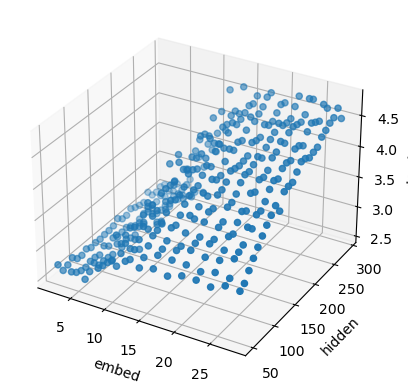

In [420]:
xs = [_[0] for _ in result]
ys = [_[1] for _ in result]
zs = [_[3] for _ in result]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('embed')
ax.set_ylabel('hidden')
ax.set_zlabel('dev loss')

In [303]:
def try_ls(lr):
    params = init_params()
    train_loss, _ = fit(params, lr, 100)
    return train_loss

lrs = torch.linspace(-8, 0, steps=1000).exp()
loss = [try_ls(lr) for lr in lrs]

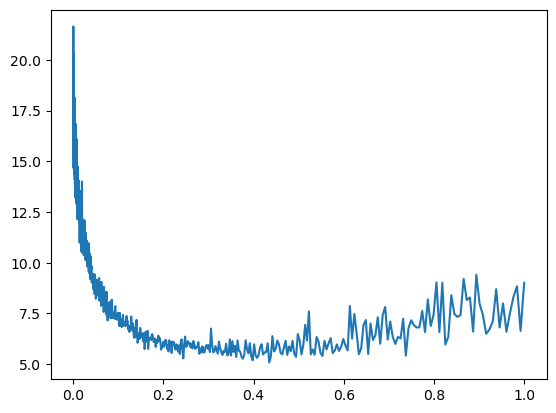

In [304]:
plot.plot(lrs, loss)

## Train Final Model

In [527]:
params = init_params(10, 200)

In [528]:
print(fit(params, 0.1, 20000))
print(fit(params, 0.01, 30000))
print(fit(params, 0.001, 50000))

(2.413909435272217, 2.448572874069214)
(2.244382619857788, 2.280365228652954)
(2.2232823371887207, 2.259216070175171)


In [ ]:
print(fit(params, 0.001, 300000))

In [516]:
def sample():
    C, W1, b1, W2, b2 = params
    sp = [0] * ctx_size
    emb_size = C.shape[1]

    for _ in range(1000):
        x = torch.tensor([sp[-3:]])
        emb = C[x].view(-1, emb_size * ctx_size)
        h = emb @ W1 + b1
        h = h.tanh()
        h = h @ W2 + b2
        prob = F.softmax(h, dim=1)
        prob = prob[0]
        ix = torch.multinomial(prob, 1).item()
        sp.append(ix)

        if ix == 0:
            break;

    return "".join([itoc[ix] for ix in sp[3:-1]])

In [523]:
for _ in range(10):
    print(sample())

muvarine
wre
selyn
daleydanglarjoa
jariub
jecilavian
sillimiez
lollaniostbalynn
eokarsia
mard
